# <center> CM3070 Final Project

## <center> Skin Cancer Detection with Deep Learning Classification Techniques

This project attempts to develop an ensemble model optimised for skin cancer detection using the HAM10000 skin lesion dataset. The model consists of two sub-models which are a convolutional neural network(CNN) and a vision transformer(ViT). The dataset will be split into train and tests sets, adhering to the hold-out protocol of reserving a portion of the dataset for validation(test) purposes.

The CNN model will be developed in accordance to the following steps: 

- Develop a first underfitting model with statistical power
- Develop a larger overfitting model
- Regularize overfitting model and tune hyperparameters based on validation performance
- Retrain on entire training set
- Evaluate on unseen test set

The ViT model will only have one iteration of model development as it is contains pretraining on other image classification data.

The models will then be combined into an ensemble model and evaluated.

To monitor and evaluate the models, success criterion and monitoring metrics will be the focussed on training and validation accuracy. 
A classification report of precision, recall, f1-score, support metrics will also be generated.



### Install and import required dependencies

In [ ]:
!pip install keras
!pip install tensorflow
!pip install scikit-learn
!pip install keras-models
!pip install vit-keras
!pip install tensorflow-addons
!pip install pandas
!pip install Pillow
!pip install numpy
!pip install seaborn

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
import itertools

import keras
from keras import regularizers
from keras.engine import training
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Average, Input, BatchNormalization
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from vit_keras import vit
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
import math

# For result reproducibility
np.random.seed(123)

### Samples and labels

This section loads in the HAM10000 dataset and prepares it in dataframes while providing general information on it.

In [2]:
# Merge images from both folders of HAM10000 dataset into one dictionary
base_skin_dir = os.path.join('./data')

image_id_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# Dictionary of labels
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [3]:
# Read metadata csv 
lesions_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
lesions_df.tail()


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back,vidir_modern


In [4]:
# Add some columns for lesions type and file path
lesions_df['path'] = lesions_df['image_id'].map(image_id_dict.get)
lesions_df['cell_type'] = lesions_df['dx'].map(lesion_type_dict.get) 
lesions_df['cell_type_idx'] = pd.Categorical(lesions_df['cell_type']).codes
lesions_df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx
9725,HAM_0004376,ISIC_0024843,akiec,histo,70.0,female,face,rosendahl,./data\HAM10000_images_part_1\ISIC_0024843.jpg,Actinic keratoses,0
6059,HAM_0003024,ISIC_0024768,nv,follow_up,35.0,female,trunk,vidir_molemax,./data\HAM10000_images_part_1\ISIC_0024768.jpg,Melanocytic nevi,4
4540,HAM_0001659,ISIC_0026564,nv,follow_up,35.0,male,lower extremity,vidir_molemax,./data\HAM10000_images_part_1\ISIC_0026564.jpg,Melanocytic nevi,4
3817,HAM_0004625,ISIC_0029346,nv,follow_up,40.0,male,upper extremity,vidir_molemax,./data\HAM10000_images_part_2\ISIC_0029346.jpg,Melanocytic nevi,4
7914,HAM_0000443,ISIC_0034271,nv,histo,35.0,female,back,vidir_modern,./data\HAM10000_images_part_2\ISIC_0034271.jpg,Melanocytic nevi,4


In [5]:
# Display dataset information
lesions_df.describe(exclude=[np.number])


,lesion_id,image_id,dx,dx_type,sex,localization,dataset,path,cell_type
count,10015,10015,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,4,10015,7
top,HAM_0001863,ISIC_0031821,nv,histo,male,back,vidir_molemax,./data\HAM10000_images_part_1\ISIC_0027806.jpg,Melanocytic nevi
freq,6,1,6705,5340,5406,2192,3954,1,6705


### Exploratory Data Visualisation

Here the dataset is visualised by plotting bar graphs and displaying the image samples to be used.

<AxesSubplot:>

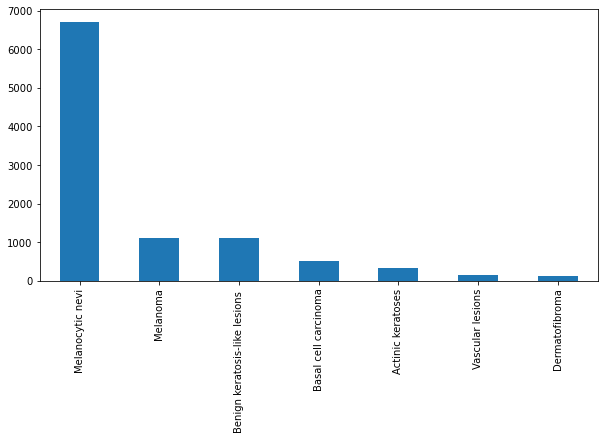

In [6]:
# Visualisation of the general distribution of classes
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
lesions_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)


<AxesSubplot:>

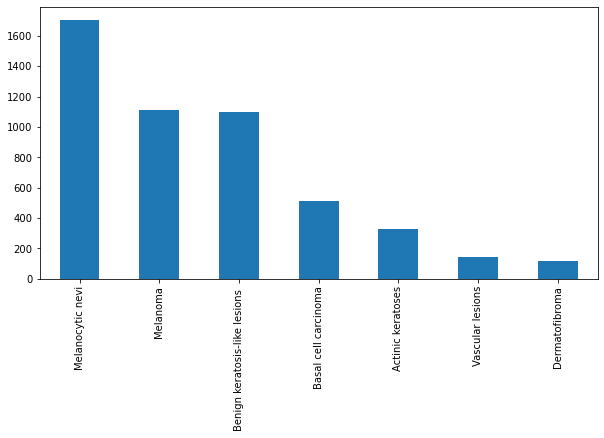

In [7]:
# Balancing the dataset by reducing samples from class with highest number of samples
lesions_df = lesions_df.drop(lesions_df[lesions_df.cell_type_idx == 4].iloc[:5000].index)

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
lesions_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)



In [8]:
# Load images to memory and resize image to 32x32
input_dimensions = (32, 32)
input_shape = input_dimensions + (3,)

lesions_df['image'] = lesions_df['path'].map(lambda x: np.asarray(Image.open(x).resize(input_dimensions)))

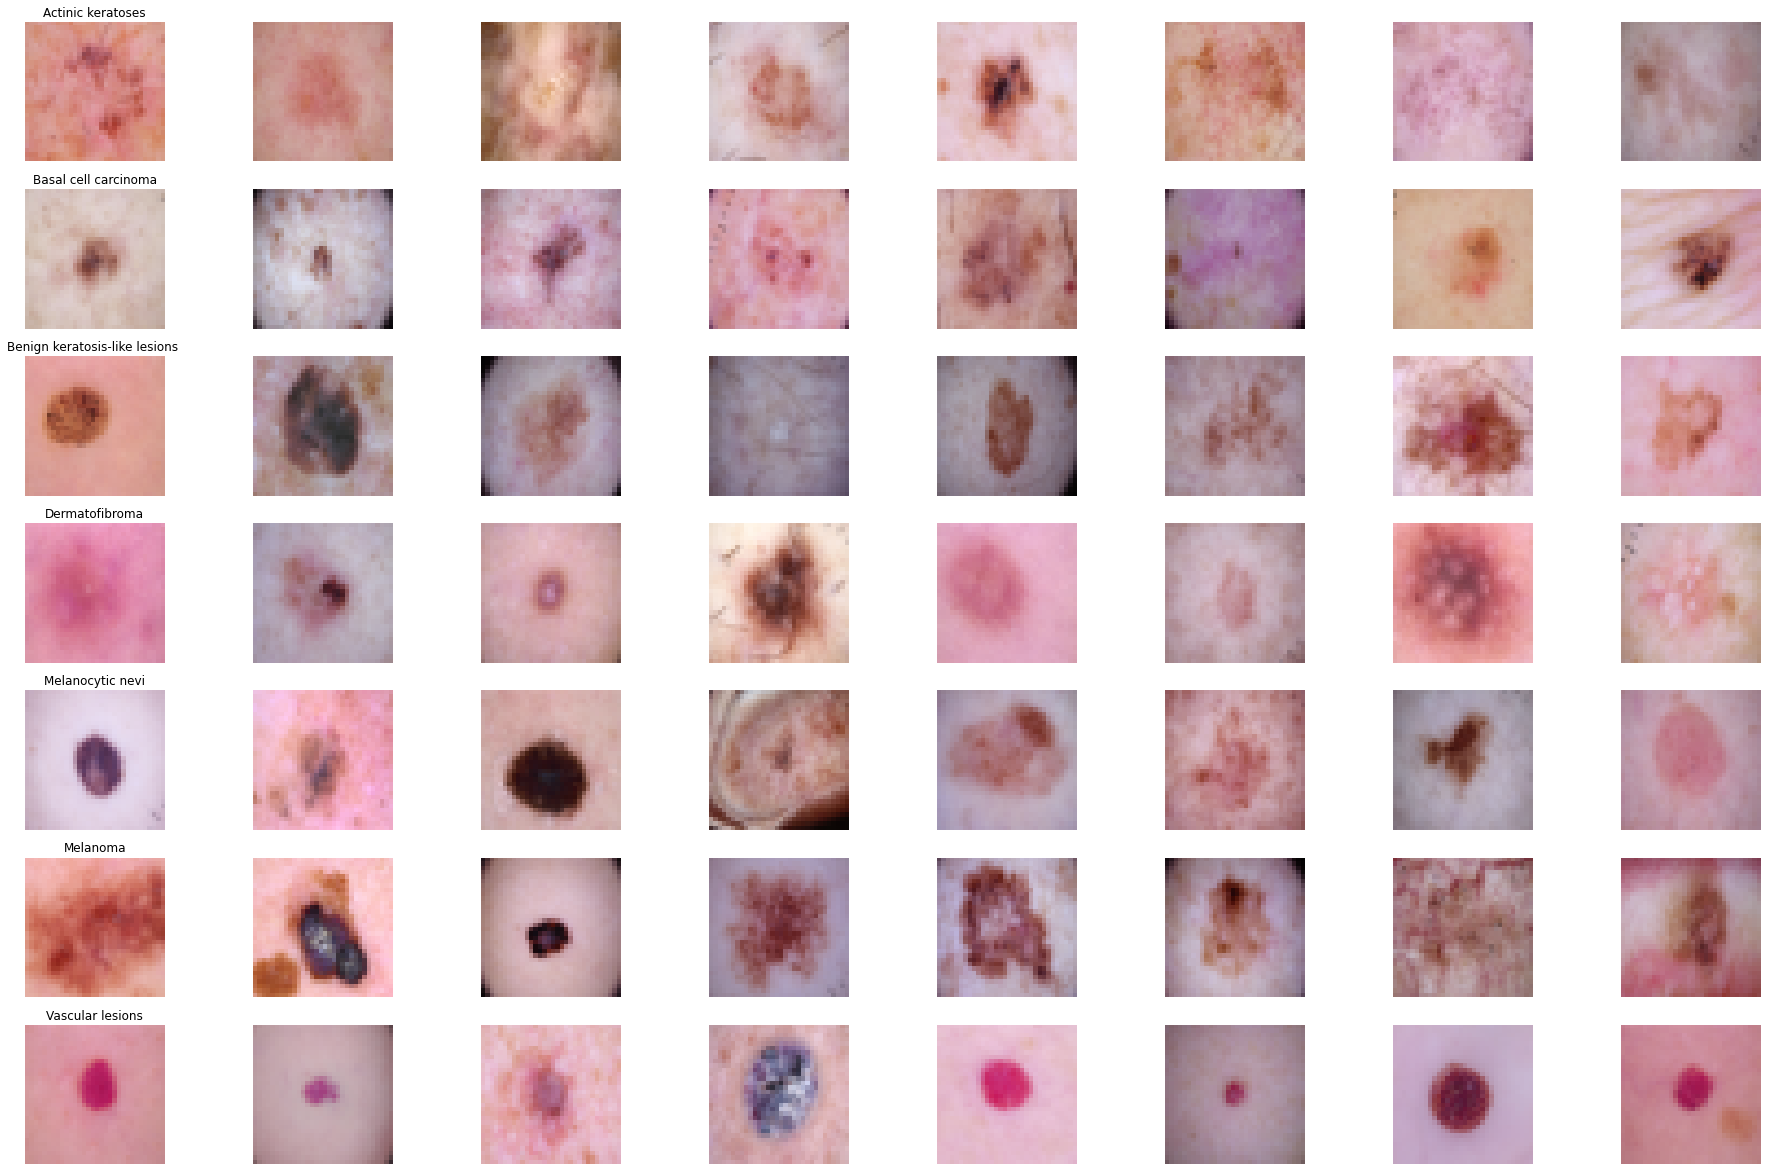

In [9]:
# Visualise the images
num_samples = 8
fig, m_axs = plt.subplots(7, num_samples, figsize = (4*num_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, lesions_df.sort_values(['cell_type']).groupby('cell_type')):
    
    n_axs[0].set_title(type_name)
    
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(num_samples, random_state=200).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [10]:
# Display number of images to be used
lesions_df['image'].map(lambda x: x.shape).value_counts()

(32, 32, 3)    5015
Name: image, dtype: int64

### Plotting helper functions

The functions are created to assist in plotting the performance of the models in later sections.

In [11]:
# Helper function to plot accuracy and loss
def plot_loss_accuracy(model_history):
    fig, ax = plt.subplots(2,1)
    ax[0].plot(model_history.history['loss'], color='b', label="Training loss")
    ax[0].plot(model_history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)
    ax[1].plot(model_history.history['accuracy'], color='b', label="Training accuracy")
    ax[1].plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)

### Preprocess data

This section splits the dataset into train and test sets, and performing data transforms to ensure that the data is in an appropriate form for model training. Data is also made more robust via data augmentation, which applies geometric transformations.

In [12]:
# Split into training and test sets
y = lesions_df.cell_type_idx
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(lesions_df, y, test_size=0.2)

x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train_validate = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std
validate_range = len(x_train) * 0.2

# Split test set further into validation set for real-time evaluation and final unseen test set
x_validate = x_train_validate[:int(validate_range)]
x_train = x_train_validate[int(validate_range):]



In [13]:
# Perform one-hot encoding
y_train_validate = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

# Split test set further into validation set for real-time evaluation and final unseen test set
y_validate = y_train_validate[:int(validate_range)]
y_train = y_train_validate[int(validate_range):]

Geometric data augmention using rotations to ensure each batch of samples are transformed to be slightly distinct, reducing the chance that the model encounters same images multiple times.

In [14]:
# Geometric data augmentation
data_aug = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        horizontal_flip=False,
        vertical_flip=False
)

data_aug.fit(x_train)

### Developing a basic underfitting Convolutional neural network(CNN) model

In [96]:
# Some parameters for training
input_shape = (32, 32, 3)
num_classes = 7
batch_size = 128 
epochs = 25

In [97]:
# Building the CNN model
cnn_underfit = Sequential()
cnn_underfit.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
cnn_underfit.add(Conv2D(32, (3, 3), activation='relu'))
cnn_underfit.add(MaxPool2D(pool_size=(2, 2)))
cnn_underfit.add(Flatten())
cnn_underfit.add(Dense(num_classes, activation='relu'))

In [98]:
# Compile the CNN model
cnn_underfit.compile(loss=keras.losses.categorical_crossentropy,
              optimizer="adam",
              metrics=['accuracy'])
cnn_underfit.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_76 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 flatten_24 (Flatten)        (None, 6272)              0         
                                                                 
 dense_24 (Dense)            (None, 7)                 43911     
                                                                 
Total params: 54,055
Trainable params: 54,055
Non-trainable params: 0
_________________________________________________

In [99]:
# Train the CNN model
cnn_underfit_history = cnn_underfit.fit(data_aug.flow(x_train, y_train, batch_size=batch_size),
                     epochs = epochs, validation_data = (x_validate, y_validate),
                     verbose = 1)



Epoch 1/25
26/26 [==============================] - 3s 81ms/step - loss: 2.3706 - accuracy: 0.3364 - val_loss: 2.1818 - val_accuracy: 0.3529
Epoch 2/25
26/26 [==============================] - 2s 76ms/step - loss: 2.1737 - accuracy: 0.3592 - val_loss: 2.1262 - val_accuracy: 0.3903
Epoch 3/25
26/26 [==============================] - 2s 79ms/step - loss: 2.1109 - accuracy: 0.3822 - val_loss: 2.0802 - val_accuracy: 0.4027
Epoch 4/25
26/26 [==============================] - 2s 78ms/step - loss: 2.1305 - accuracy: 0.4031 - val_loss: 2.0923 - val_accuracy: 0.4140
Epoch 5/25
26/26 [==============================] - 2s 76ms/step - loss: 2.1016 - accuracy: 0.3978 - val_loss: 2.1093 - val_accuracy: 0.4102
Epoch 6/25
26/26 [==============================] - 2s 83ms/step - loss: 2.0937 - accuracy: 0.3928 - val_loss: 2.1189 - val_accuracy: 0.4015
Epoch 7/25
26/26 [==============================] - 2s 77ms/step - loss: 2.1639 - accuracy: 0.3436 - val_loss: 2.3565 - val_accuracy: 0.1297
Epoch 8/25
26

### Developing an overfitting CNN model

In [22]:
# Building CNN model
cnn_overfit = Sequential()
cnn_overfit.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
cnn_overfit.add(Conv2D(64, (3, 3), activation='relu'))
cnn_overfit.add(MaxPool2D(pool_size=(2, 2)))
cnn_overfit.add(Conv2D(128, (3, 3), activation='relu'))
cnn_overfit.add(MaxPool2D(pool_size=(3, 3)))
cnn_overfit.add(Conv2D(256, (3, 3), activation='relu'))
cnn_overfit.add(MaxPool2D(pool_size=(2, 2)))
cnn_overfit.add(Flatten())
cnn_overfit.add(Dense(num_classes, activation='softmax'))

In [23]:
# Compile CNN model
cnn_overfit.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
cnn_overfit.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 128)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 2, 2, 256)        

In [24]:
# Train CNN model
cnn_overfit_history = cnn_overfit.fit(data_aug.flow(x_train, y_train, batch_size=batch_size),
                     epochs = epochs, validation_data = (x_validate, y_validate),
                     verbose = 1)

Epoch 1/25
26/26 [==============================] - 5s 174ms/step - loss: 1.5294 - accuracy: 0.3502 - val_loss: 1.4646 - val_accuracy: 0.4115
Epoch 2/25
26/26 [==============================] - 4s 170ms/step - loss: 1.3926 - accuracy: 0.4358 - val_loss: 1.3375 - val_accuracy: 0.4539
Epoch 3/25
26/26 [==============================] - 4s 158ms/step - loss: 1.3240 - accuracy: 0.4592 - val_loss: 1.3033 - val_accuracy: 0.4776
Epoch 4/25
26/26 [==============================] - 4s 158ms/step - loss: 1.2730 - accuracy: 0.4875 - val_loss: 1.2490 - val_accuracy: 0.5100
Epoch 5/25
26/26 [==============================] - 4s 159ms/step - loss: 1.2301 - accuracy: 0.4838 - val_loss: 1.2108 - val_accuracy: 0.5436
Epoch 6/25
26/26 [==============================] - 4s 160ms/step - loss: 1.1818 - accuracy: 0.5336 - val_loss: 1.2331 - val_accuracy: 0.5112
Epoch 7/25
26/26 [==============================] - 4s 157ms/step - loss: 1.1416 - accuracy: 0.5511 - val_loss: 1.2300 - val_accuracy: 0.4863
Epoch 

### Regularising and tuning hyperparameters of overfitting CNN model

In [125]:
# Building and tuning CNN model
cnn_final = Sequential()
cnn_final.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
cnn_final.add(Dropout(0.1))
cnn_final.add(Conv2D(64, (3, 3), activation='relu'))
cnn_final.add(BatchNormalization())
cnn_final.add(MaxPool2D(pool_size=(2, 2)))
cnn_final.add(Dropout(0.3))
cnn_final.add(Conv2D(128, (3, 3), activation='relu'))
cnn_final.add(BatchNormalization())
cnn_final.add(MaxPool2D(pool_size=(2, 2)))
cnn_final.add(Dropout(0.5))
cnn_final.add(Flatten())
cnn_final.add(Dense(num_classes, activation='softmax'))

In [126]:
# Compile CNN model
cnn_final.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
              metrics=['accuracy'])
cnn_final.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_77 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 dropout_56 (Dropout)        (None, 30, 30, 32)        0         
                                                                 
 conv2d_78 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_8 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 dropout_57 (Dropout)        (None, 14, 14, 64)      

In [127]:
# Train CNN model
cnn_final_history = cnn_final.fit(data_aug.flow(x_train, y_train, batch_size=32),
                     epochs = epochs, validation_data = (x_validate, y_validate),
                     verbose = 1)

Epoch 1/25
101/101 [==============================] - 10s 90ms/step - loss: 2.8441 - accuracy: 0.3617 - val_loss: 1.7136 - val_accuracy: 0.3554
Epoch 2/25
101/101 [==============================] - 9s 85ms/step - loss: 2.4188 - accuracy: 0.3875 - val_loss: 2.1652 - val_accuracy: 0.3853
Epoch 3/25
101/101 [==============================] - 9s 85ms/step - loss: 2.3524 - accuracy: 0.4143 - val_loss: 1.6956 - val_accuracy: 0.4638
Epoch 4/25
101/101 [==============================] - 9s 85ms/step - loss: 2.1225 - accuracy: 0.4305 - val_loss: 1.7482 - val_accuracy: 0.4002
Epoch 5/25
101/101 [==============================] - 9s 85ms/step - loss: 1.9717 - accuracy: 0.4414 - val_loss: 1.8158 - val_accuracy: 0.4800
Epoch 6/25
101/101 [==============================] - 9s 85ms/step - loss: 1.9254 - accuracy: 0.4583 - val_loss: 2.2232 - val_accuracy: 0.4426
Epoch 7/25
101/101 [==============================] - 9s 85ms/step - loss: 1.8521 - accuracy: 0.4822 - val_loss: 1.8521 - val_accuracy: 0.507

### CNN performance evaluation on training data

Graphs for training and validation loss and accuracy for all three CNN models.

Underfitting model


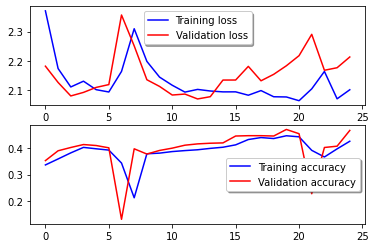

In [100]:
# Plot training and validation loss and accuracy
print('Underfitting model')
plot_loss_accuracy(cnn_underfit_history)

Overfitting model


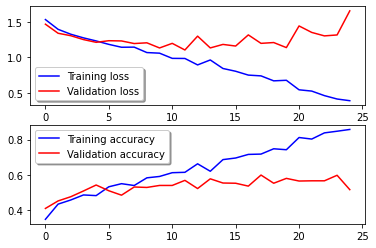

In [89]:
print('Overfitting model')
plot_loss_accuracy(cnn_overfit_history)

Final model


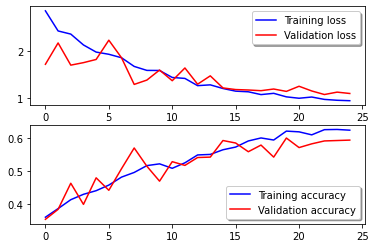

In [128]:
print('Final CNN model')
plot_loss_accuracy(cnn_final_history)

### Retrain final CNN model on entire training set and evaluate on unseen test set

In [130]:
cnn_final_history = cnn_final.fit(data_aug.flow(x_train_validate, y_train_validate, batch_size=32),
                     epochs = epochs, 
                     verbose = 1)

Epoch 1/25
126/126 [==============================] - 10s 81ms/step - loss: 0.9952 - accuracy: 0.6224
Epoch 2/25
126/126 [==============================] - 10s 81ms/step - loss: 0.9501 - accuracy: 0.6304
Epoch 3/25
126/126 [==============================] - 10s 81ms/step - loss: 0.9329 - accuracy: 0.6361
Epoch 4/25
126/126 [==============================] - 10s 81ms/step - loss: 0.9306 - accuracy: 0.6358
Epoch 5/25
126/126 [==============================] - 10s 81ms/step - loss: 0.9322 - accuracy: 0.6291
Epoch 6/25
126/126 [==============================] - 10s 81ms/step - loss: 0.9059 - accuracy: 0.6530
Epoch 7/25
126/126 [==============================] - 10s 81ms/step - loss: 0.8912 - accuracy: 0.6583
Epoch 8/25
126/126 [==============================] - 10s 81ms/step - loss: 0.9059 - accuracy: 0.6503
Epoch 9/25
126/126 [==============================] - 10s 81ms/step - loss: 0.8791 - accuracy: 0.6625
Epoch 10/25
126/126 [==============================] - 10s 81ms/step - loss: 0.884

Evaluate final CNN model on unseen test set.

In [131]:
metric_score = cnn_final.evaluate(x_test, y_test)
print('Test loss:', metric_score[0])
print('Test accuracy:', metric_score[1])

32/32 [==============================] - 1s 18ms/step - loss: 1.0451 - accuracy: 0.6221
Test loss: 1.0451096296310425
Test accuracy: 0.6221336126327515


CNN classification report.

In [137]:
y_pred = np.argmax(cnn_final.predict(x_test), axis=1)
y_pred_bool = np.argmax(y_test, axis=1)

print(classification_report(y_pred, y_pred_bool))

              precision    recall  f1-score   support

           0       0.33      0.60      0.43        40
           1       0.58      0.69      0.63        89
           2       0.62      0.58      0.60       255
           3       0.52      0.86      0.65        14
           4       0.76      0.65      0.70       383
           5       0.51      0.54      0.53       197
           6       0.88      0.88      0.88        25

    accuracy                           0.62      1003
   macro avg       0.60      0.69      0.63      1003
weighted avg       0.64      0.62      0.63      1003



### Developing the Vision Transformer(ViT) model

In [233]:
# Setting parameters for training
vit_arch = vit.vit_b32(
        image_size = 32,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = num_classes)

In [234]:
# Building the VIT model
vit_final = tf.keras.Sequential([
        vit_arch,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(num_classes, 'softmax')
    ],
    name = 'ViT_final')

vit_final.summary()

Model: "ViT_final"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87418368  
                                                                 
 flatten_52 (Flatten)        (None, 768)               0         
                                                                 
 dense_84 (Dense)            (None, 11)                8459      
                                                                 
 dense_85 (Dense)            (None, 7)                 84        
                                                                 
Total params: 87,426,911
Trainable params: 87,426,911
Non-trainable params: 0
_________________________________________________________________


In [235]:
# Compile ViT Model
vit_final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),loss=keras.losses.categorical_crossentropy,metrics=['accuracy'],
                 )

In [236]:
# Training ViT model

vit_final_history = vit_final.fit(data_aug.flow(x_train, y_train, batch_size=32),
                     epochs = epochs, validation_data = (x_validate, y_validate),
                     verbose = 1)
     

Epoch 1/25
101/101 [==============================] - 136s 1s/step - loss: 1.7134 - accuracy: 0.3349 - val_loss: 1.5278 - val_accuracy: 0.3903
Epoch 2/25
101/101 [==============================] - 114s 1s/step - loss: 1.5233 - accuracy: 0.3776 - val_loss: 1.4313 - val_accuracy: 0.4451
Epoch 3/25
101/101 [==============================] - 114s 1s/step - loss: 1.4410 - accuracy: 0.4209 - val_loss: 1.4282 - val_accuracy: 0.4352
Epoch 4/25
101/101 [==============================] - 114s 1s/step - loss: 1.3950 - accuracy: 0.4299 - val_loss: 1.3660 - val_accuracy: 0.4364
Epoch 5/25
101/101 [==============================] - 114s 1s/step - loss: 1.3635 - accuracy: 0.4642 - val_loss: 1.3906 - val_accuracy: 0.4626
Epoch 6/25
101/101 [==============================] - 114s 1s/step - loss: 1.3306 - accuracy: 0.4782 - val_loss: 1.2880 - val_accuracy: 0.5187
Epoch 7/25
101/101 [==============================] - 115s 1s/step - loss: 1.3062 - accuracy: 0.4804 - val_loss: 1.3020 - val_accuracy: 0.5112

### ViT performance evaluation on training data

Graphs for training and validation loss and accuracy of ViT model.

Final ViT model


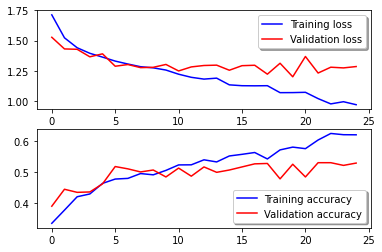

In [237]:
print('Final ViT model')
plot_loss_accuracy(vit_final_history)

### Retrain ViT model on entire training set and evaluate on unseen test set

In [238]:
vit_final_history = vit_final.fit(data_aug.flow(x_train_validate, y_train_validate, batch_size=batch_size),
                     epochs = epochs,
                     verbose = 1)

Epoch 1/25
32/32 [==============================] - 92s 3s/step - loss: 0.9112 - accuracy: 0.6610
Epoch 2/25
32/32 [==============================] - 91s 3s/step - loss: 0.8163 - accuracy: 0.6967
Epoch 3/25
32/32 [==============================] - 92s 3s/step - loss: 0.7531 - accuracy: 0.7141
Epoch 4/25
32/32 [==============================] - 92s 3s/step - loss: 0.7230 - accuracy: 0.7303
Epoch 5/25
32/32 [==============================] - 92s 3s/step - loss: 0.7038 - accuracy: 0.7400
Epoch 6/25
32/32 [==============================] - 92s 3s/step - loss: 0.6809 - accuracy: 0.7440
Epoch 7/25
32/32 [==============================] - 93s 3s/step - loss: 0.6777 - accuracy: 0.7343
Epoch 8/25
32/32 [==============================] - 92s 3s/step - loss: 0.6249 - accuracy: 0.7627
Epoch 9/25
32/32 [==============================] - 91s 3s/step - loss: 0.6265 - accuracy: 0.7635
Epoch 10/25
32/32 [==============================] - 93s 3s/step - loss: 0.6036 - accuracy: 0.7727
Epoch 11/25
32/32 [

Evaluate ViT model on unseen test set

In [239]:
metric_score = vit_final.evaluate(x_test, y_test)
print('Test loss:', metric_score[0])
print('Test accuracy:', metric_score[1])

32/32 [==============================] - 13s 412ms/step - loss: 2.0327 - accuracy: 0.5224
Test loss: 2.032688617706299
Test accuracy: 0.5224326848983765


ViT classification report. 

In [240]:
y_pred = np.argmax(vit_final.predict(x_test), axis=1)
y_pred_bool = np.argmax(y_test, axis=1)

print(classification_report(y_pred, y_pred_bool))

              precision    recall  f1-score   support

           0       0.50      0.40      0.44        90
           1       0.33      0.57      0.42        61
           2       0.53      0.51      0.52       248
           3       0.22      0.26      0.24        19
           4       0.59      0.62      0.61       312
           5       0.56      0.47      0.51       247
           6       0.48      0.46      0.47        26

    accuracy                           0.52      1003
   macro avg       0.46      0.47      0.46      1003
weighted avg       0.53      0.52      0.52      1003



### Putting it together: the ensemble model

Averaging the outputs of CNN and ViT models to form an ensemble model predictor.

In [241]:
# Building the ensemble by combining sub-models

models = [cnn_final, vit_final]
model_input = tf.keras.Input(shape=(32,32,3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

Testing the ensemble model on unseen test set.

In [242]:
ensemble_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
metric_score = ensemble_model.evaluate(x_test, y_test)
print('Test loss:', metric_score[0])
print('Test accuracy:', metric_score[1])

32/32 [==============================] - 19s 435ms/step - loss: 1.1940 - accuracy: 0.6271
Test loss: 1.1939939260482788
Test accuracy: 0.6271186470985413


Ensemble classification report.

In [243]:
y_pred = np.argmax(ensemble_model.predict(x_test), axis=1)
y_pred_bool = np.argmax(y_test, axis=1)

print(classification_report(y_pred, y_pred_bool))

              precision    recall  f1-score   support

           0       0.57      0.50      0.53        82
           1       0.47      0.69      0.56        72
           2       0.56      0.61      0.58       222
           3       0.48      0.69      0.56        16
           4       0.78      0.66      0.71       388
           5       0.56      0.60      0.58       195
           6       0.80      0.71      0.75        28

    accuracy                           0.63      1003
   macro avg       0.60      0.64      0.61      1003
weighted avg       0.64      0.63      0.63      1003

